In [15]:
# Paper link: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
# References: https://sorenbouma.github.io/blog/oneshot/, http://cs231n.github.io/neural-networks-2/#reg

# Import necessary libraries from keras and others
from keras.models import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, merge
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from keras import backend as K
from scipy.misc import imresize
import numpy as np
import seaborn as sns

# Display image in the notebook
%matplotlib inline

In [2]:
def resize_images(image):
    """
    Resize the image to be 105x105 so it follows the similar format according to the paper.
    """
    return imresize(image, size=(105, 105))

def conv_kernel_init():
    """
    Initialize weights for the convolutional layers from a normal 
    distribution with zero-mean and standard deviation of 0.01 according to the paper.
    """
    return RandomNormal(mean=0, stddev=0.01)

def bias_init():
    """
    Initialize bias for the convolutional layers from a normal
    distribution with mean of 0.5 and standard deviation of 0.01 according to the paper.
    """
    return RandomNormal(mean=0.5, stddev=0.01)

def get_batch_data(data, num_pairs):
    """
    Generate pairs of training data. Half of the pairs will have the same classes and the other half would be different.
    """
    left_child_data = []
    right_child_data = []
    labels = np.zeros(num_pairs)
    labels[:num_pairs // 2] = 1
    num_classes = len(data.keys())
    
    for i in range(num_pairs):
        first_category = np.random.choice(list(data.keys()))
        second_category = first_category if i < num_pairs // 2 else (first_category + np.random.randint(1, num_classes)) % num_classes
        first_image = data[first_category][np.random.choice(len(data[first_category]))].reshape((105, 105, 1))
        second_image = data[second_category][np.random.choice(len(data[second_category]))].reshape((105, 105, 1))
        left_child_data.append(first_image)
        right_child_data.append(second_image)
    
    return np.array(left_child_data), np.array(right_child_data), labels

def get_n_way_data(data, ways):
    """
    Generate N-ways data for a single one-shot classification task.
    """
    labels = np.zeros(ways)
    labels[0] = 1
    
    categories = np.random.choice(list(data.keys()), ways, replace=False)
    fixed_category = categories[0]
    fixed_image = data[fixed_category][np.random.choice(len(data[fixed_category]))].reshape((105, 105, 1))
    left_child_data = [fixed_image] * ways
    right_child_data = []
    
    for current_category in categories:
        right_child_data.append(data[current_category][np.random.choice(len(data[current_category]))].reshape((105, 105, 1)))
    
    return np.array(left_child_data), np.array(right_child_data), labels

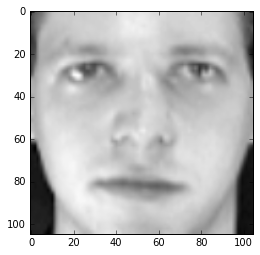

In [3]:
bunch = fetch_olivetti_faces()
images, categories = bunch['images'], bunch['target']

# Resize images to mimic the input size from the paper
data = []
for current_image in images:
    data.append(resize_images(current_image))
data = np.array(data)

combined_data = {}

# Splitting out the images by its labels
for i, current_label in enumerate(categories):
    current_image = data[i]
    if current_label not in combined_data:
        combined_data[current_label] = []
    combined_data[current_label].append(current_image)

# Checking the first face image
plt.imshow(data[0], cmap='gray')

In [10]:
K.set_image_dim_ordering('tf')
input_shape = (105, 105, 1)
left_child_input = Input(input_shape)
right_child_input = Input(input_shape)

# Model Architecture
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(10, 10), input_shape=input_shape, activation='relu', 
                 kernel_initializer=conv_kernel_init(), bias_initializer=bias_init()))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(7, 7), activation='relu',
                kernel_initializer=conv_kernel_init(), bias_initializer=bias_init()))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu',
                kernel_initializer=conv_kernel_init(), bias_initializer=bias_init()))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=256, kernel_size=(4, 4), activation='relu',
                kernel_initializer=conv_kernel_init(), bias_initializer=bias_init()))
model.add(Flatten())
# Fully-connected layers will have a different weight initialization according to the paper
model.add(Dense(units=4096, activation='sigmoid',
                kernel_initializer=RandomNormal(mean=0, stddev=0.2), bias_initializer=bias_init()))

left_child_model = model(inputs=left_child_input)
right_child_model = model(inputs=right_child_input)
combined_model = merge(inputs=[left_child_model, right_child_model], mode=lambda p: K.abs(p[0] - p[1]),
                      output_shape=lambda m: m[0])
output_model = Dense(units=1, activation='sigmoid', 
                     kernel_initializer=RandomNormal(mean=0, stddev=0.2), bias_initializer=bias_init())(combined_model)
overall_model = Model(inputs=[left_child_input, right_child_input], outputs=output_model)
overall_model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [5]:
# Check out the overall model architecture
overall_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 105, 105, 1)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 105, 105, 1)   0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 4096)          38947648    input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
merge_1 (Merge)                  (None, 4096)          0           sequential_1[1][0]      

In [ ]:
# Training
batch_size = 32
N_ways = 10
num_tasks = 100
epochs = 1000
record_counter = 5
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for iteration in range(epochs):
    left_child_data, right_child_data, label = get_batch_data(combined_data, batch_size)
    result = overall_model.train_on_batch(x=[left_child_data, right_child_data], y=label)
    train_loss = result[0]
    train_accuracy = result[1]
    
    if iteration % record_counter == 0:
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        num_correct = 0.0
        # Running N-ways classification for num_tasks time
        for i in range(num_tasks):
            left_child_test, right_child_test, label_test = get_n_way_data(combined_data, N_ways)
            probabilities = overall_model.predict(x=[left_child_test, right_child_test])
            if np.argmax(probabilities) == 0:
                num_correct += 1.0
        
        test_accuracy = num_correct / num_tasks
        test_accuracy_list.append(test_accuracy)    

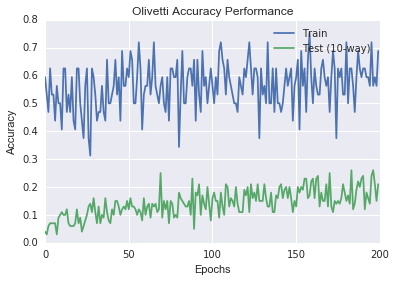

In [47]:
plt.plot(train_accuracy_list, label='Train')
plt.plot(test_accuracy_list, label='Test (10-way)')
plt.legend()
plt.title('Olivetti Accuracy Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

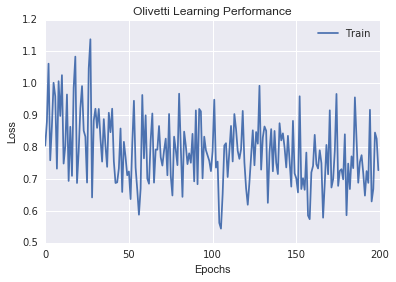

In [48]:
plt.plot(train_loss_list, label='Train')
plt.title('Olivetti Learning Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Future Works
#### Find out why is it not converging properly
- Architecture setup issues?
- Not setting up the optimizer properly?
- Affine distortion?
- Not enough data?

#### Show other performance metrics
- Precision
- Recall
- F1 score

#### Data augmentation tricks that I could've used
- Translation
- Zoom in/out
- Rotation
- Flip
- Adjusting brightness

#### Architecture Optimization
- Maybe adding some dropout layers?
- Max-norm regularization?